# Apprentissage statitisque : Les méthodes ensemblistes 

Il s'agit de l'utilisation de plusieurs estimateurs pour amélorier la qualité des prédictions. On en distingue au moins deux types méthodes :
* Les méthodes parallèles, exemple : bagging
* Les méthodes séquentielles, exemple : boosting

# A. Bootstrap aggregating (Bagging)

Le bagging consiste à :
* Construire `B` échantillons Boostrap
* Créer un estimateur avec chaque échantillon
* Pour prédire :
  * moyenneer les prédictions des estimateurs pour une régression
  * prendre la classe majoritaire dans les prédictions des estimateurs pour une classification
  
Le bagging combine les prédictions de plusieurs modèles indépendants pour réduire la variance. Donc l'utilisation du bagging est plutôt adapté aux modèles instables (à fortes variances) comme les arbres de décision ou les réseaux de neurones.

## A.1 Random Forests

Les Forêts aléatoires ont été introduites par Breiman en 2001. Les RF sont un bagging d'arbres mais introduisent deux points pour diminuer la variance (instabilité du modèle) :
* Chaque arbre est construit avec un échantillon boostrap
* Au moment de diviser un nœud, les RF sélectionnent aléatoirement un nombre réduit de variables. Les RF utilisent une heuristique pour trouver la meilleure division d'un nœud.
L'objectif de ces opérations est de construire des arbres décorrélés.

## A.2  Extremely Randomized Trees (ERT)

Cette méthode statistique est très similaire aux Random Forets. Cependant elle apporte deux différences majeures :
* Les ERT utilisent toutes les données pour construire chaque estimateur contrairement aux RF qui utilisent des échantillons boostrap. L'implémentation de `scikit-learn` propose un paramètre pour utiliser des échantillons boostrap.
* Pour diviser un nœud, les ERT choisissent aléatoirement m variables puis de tire de façon aléatoire un seuil pour chaque variable

Cela permet de diminuer la variance et par ricochet augmente le biais.

## B. Boosting

## B.1 Boosting adaptative (AdaBoost)

Le Boosting adaptative utilise le même principe que le Bagging : construire plusieurs modèles puis agréger par la moyenne (ou le vote) les prédictions. Le boosting construit les estimateurs de façon itérative. Chaque estimateur est une version adaptative du précédent en corrigeant ses faiblesses

## B.2 Gradient Boosting

Cette méthode suppose que la fonction perte convexe et différentiable. Le principe de base est le même que pour adaBoost. Elle utilise la descente du gradient pour améliorer les performances des estimateurs. Plutôt que de chercher un meilleur classifieur comme avec adaBoost, on explore un espace de fonctions par une descente de gradient sur la fonction de perte.

## B.3 eXtrème Gradient Boosting

Il s'agit d'une implémentation optimisée de l’algorithme du Gradient Boosting. En plus XGboost propose plus de paramètres pour contrôler l'apprentissage. On peut aussi ajouter un terme de pénalisation à la fonction de perte pour éviter le surajustement


## B.4 CatBoost: unbiased boosting with categorical features

Catboost est une méthode basée sur un Gradient Boosting d'arbres de décisions. Il a été développé par les équipes Yandex et utilisé pour construire des systèmes de recommandations, les prévisions météorologiques même peut-être utilisés pour d'autres tâches d'apprentissage supervisé.
Catboost peut gérer lui mêmes les variables catégorielles. Il n'est pas conseillé d'effecter un one-hot-encoding dans l'étape de préprocessing mais fournit un paramètre permettant `one_hot_max_size` pour utiliser le one-hot-encoder pour les variables catégorielles avec peu de modalités. Il existe également un paramètre de régularisation L2 pour éviter le sur-ajustement.

## B.5 LightGBM: A Highly Efficient Gradient Boosting Decision Tree

LightGBM est une autre méthode basée sur le Gradient Boosting développé par Microsoft. Elle utilise également les arbres comme estimateurs.
LightGBM construit ses arbres différemment comparés aux autres méthodes de Boosting. En effet on distingue de façon de construire les arbres :
* **level-wise** : A chaque itération chaque feuille de l'arbre est divisée en deux noeud. De ce fait l'arbre grandit par niveau. La plupart des algorithmes utilisent cette méthode pour construire leurs arbres
* **leaf-wise** : A chaque étape, on divise seulement la feuille qui offre la meilleure division. LightGBM construit ses arbres avec cette méthode. Cette façon de construire peut favoriser le sur-ajustement, donc il faudra contrôler la profondeur des arbres.

LightGBM utilise une façon très intéressante pour gérer les variables catégorielles surtout lorsque celles-ci contiennent plusieurs modalités. Pour diviser un nœud avec une variable catégorielle, on cherche les 2 sous-groupes de catégories qui donnent la meilleure division.
Ils proposent aussi des régularisations de type L2 ou L1 ainsi le early stopping pour éviter le sur-ajustement.

## B.6 Regularized Greedy Forest (RGF)

Le RGF diffère du gradient boosting :
* RGF ajoute explicitement un terme de pénalisations à la fonction de perte.
* A chaque itération tous estimateurs sont mis à jour contrairement au GB qui met à jour seulement l'estimateur de l'itération.

## C. Stacking

Le principe du stacking est d'entrainer un modèle (méta-modèle) en utilisant comme variables explicatives (méta-features) les prédictions de différents estimateurs (base-modèles). Le stacking est différent des méthodes ensemblistes vues ci-dessous :
* Les estimateurs sont créés avec les méthodes statistiques différentes 
* On utilise un méta-modéle pour combiner les prédictions (et non la moyenne ou le vote)  

# Applications  à un problème de classification

**Score d'appétence d'un produit bancaire**

Les données proviennent du github de Wikistat. Pour avoir des informations sur les variables, vous pouvez regarder [ici](https://github.com/wikistat/Apprentissage/blob/master/GRC-carte_Visa/Apprent-Python-Visa.ipynb).

**Note :** L'objectif est de montrer comment mettre en oeuvre les algorithmes de classification. On ne cherchera pas à comparer les modèles

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import set_config
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt

sns.set()
set_config(display='diagram')
random_seed =12345

def plot_perf(true_Y, pred_Y):
    rcParams['figure.figsize'] = 10, 5

    conf_matrix = confusion_matrix(true_Y, pred_Y)
    conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

    clf_report = classification_report(test_Y, pred_Y, target_names=target_names, output_dict=True)
    clf_report = {name : clf_report[name] for name in target_names}
    _ = sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, cbar=False,  ax=ax1)
    ax1.set_title("Précision - Recall - F1-score")


    sns.heatmap(conf_matrix, xticklabels=target_names, 
                yticklabels=target_names, annot=True, fmt=".2f", cbar=False, ax=ax2)
    ax2.set_title('Matrice de confusion')
    ax2.set_xlabel('Valeurs réalisées')
    _ = ax2.set_ylabel('Valeurs prédites')

target_names = ["Non", "Oui"]

data = pd.read_table("data/vispremv.dat", sep=' ')
data.columns = data.columns.str.upper()
target = 'CARVP'
categorical_features = [feature for feature, dtype in  data.dtypes.to_dict().items() if dtype == object and feature != target]

numeric_features = [feature for feature, dtype in  data.dtypes.to_dict().items() if dtype != object and feature != target]

cat_features = [key for key, value in enumerate(data.columns.to_list()) if value in categorical_features]

data['CARVP'] = data['CARVP'].map(lambda x : 0 if x == 'Cnon' else 1)

numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                      ('scaler', StandardScaler())])
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

train, test = train_test_split(data, test_size=0.2, random_state=0)
train_Y = train[target]
preprocessor.fit(train)
train_X = preprocessor.transform(train)

test_Y = test[target]
test_X = preprocessor.transform(test)

predictions = {}

**Random Forest**

Wall time: 54.8 s


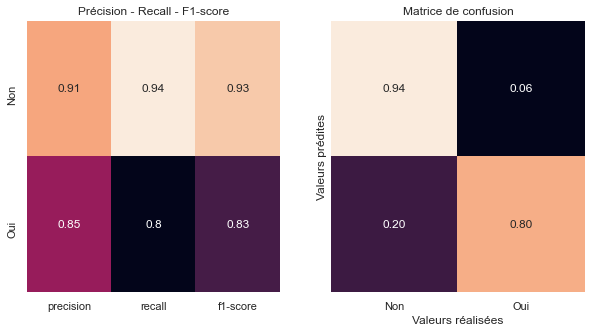

In [2]:
%%time
from sklearn.ensemble import RandomForestClassifier

param_grid = {
              "max_features": [0.6, 0.8],
              "n_estimators": [50, 100, 200, 300],
              "min_samples_split": [2, 3, 4],
              "min_samples_leaf": [2, 3, 4]
             }

rf = GridSearchCV(RandomForestClassifier(random_state=random_seed), param_grid, cv=3, n_jobs=3)
rf.fit(train_X, train_Y)
pred_Y = rf.predict(test_X)
plot_perf(test_Y, pred_Y)
predictions['RF'] = rf.predict_proba(test_X)[:, 1]

In [3]:
rf.best_estimator_

RandomForestClassifier(max_features=0.6, min_samples_leaf=2, n_estimators=200,
                       random_state=12345)

**Extremely Randomized Trees (ERT)**

Wall time: 47.3 s


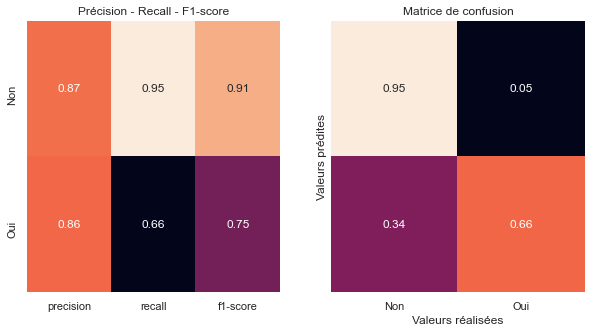

In [4]:
%%time

from sklearn.ensemble import ExtraTreesClassifier

param_grid = {
              "max_features": [0.6, 0.8],
              "n_estimators": [50, 100, 200, 300],
              "min_samples_split": [2, 3, 4],
              "min_samples_leaf": [2, 3, 4]
             }

ert = GridSearchCV(ExtraTreesClassifier(random_state=random_seed), param_grid, cv=3, n_jobs=3)
ert.fit(train_X, train_Y)
pred_Y = ert.predict(test_X)
plot_perf(test_Y, pred_Y)
predictions['ERT'] = ert.predict_proba(test_X)[:, 1]

In [5]:
ert.best_estimator_

ExtraTreesClassifier(max_features=0.6, min_samples_leaf=4, n_estimators=200,
                     random_state=12345)

**Boosting adaptative (AdaBoost)**

Wall time: 8.41 s


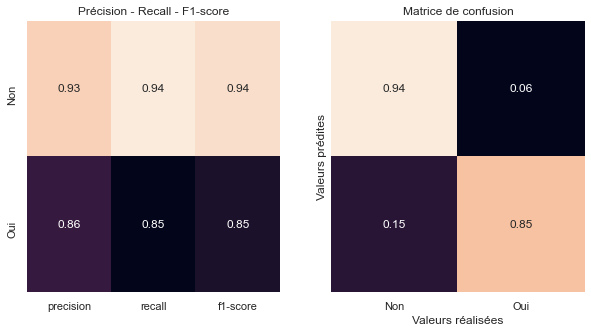

In [6]:
%%time
from sklearn.ensemble import AdaBoostClassifier

param_grid = {
              "learning_rate": [0.01, 0.05, 0.1, 0.5],
              "n_estimators": [50, 100, 200, 300]
             }

adb = GridSearchCV(AdaBoostClassifier(random_state=random_seed), param_grid, cv=3, n_jobs=3)
adb.fit(train_X, train_Y)
pred_Y = adb.predict(test_X)
plot_perf(test_Y, pred_Y)
predictions['ADB'] = adb.predict_proba(test_X)[:, 1]

In [7]:
adb.best_estimator_

AdaBoostClassifier(learning_rate=0.5, random_state=12345)

**Gradient Boosting Machine**

Wall time: 33.4 s


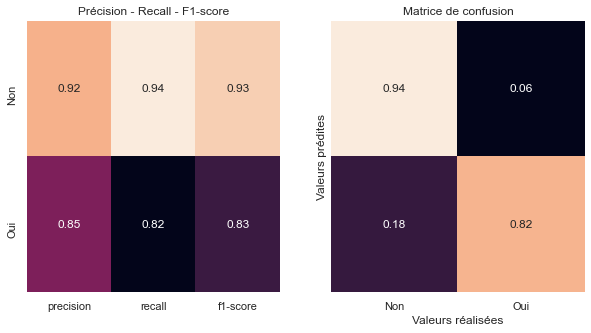

In [8]:
%%time

from sklearn.ensemble import GradientBoostingClassifier

param_grid = {
              "max_features": [0.6, 0.8],
              "n_estimators": [50, 100, 200, 300],
              "min_samples_split": [2, 3, 4],
              "min_samples_leaf": [2, 3, 4]
             }

gbm = GridSearchCV(GradientBoostingClassifier(random_state=random_seed), param_grid, cv=3, n_jobs=3)
gbm.fit(train_X, train_Y)
pred_Y = gbm.predict(test_X)
plot_perf(test_Y, pred_Y)
predictions['GBM'] = gbm.predict_proba(test_X)[:, 1]

In [9]:
gbm.best_estimator_

GradientBoostingClassifier(max_features=0.6, min_samples_leaf=3,
                           random_state=12345)

**Regularized Greedy Forest**

Wall time: 1min 6s


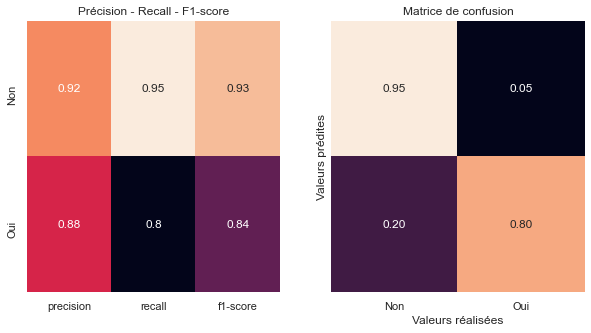

In [10]:
%%time

from rgf.sklearn import RGFClassifier
   
param_grid = {
              "learning_rate": [0.01, 0.05, 0.1, 0.5],
              "max_leaf": [10, 50, 100, 200],
              "algorithm": ["RGF", "RGF_Opt", "RGF_Sib"],
              "min_samples_leaf": [2, 3, 4],
              "loss": ["Expo", "Log"]
             }

rgf = GridSearchCV(RGFClassifier(), param_grid, cv=3, n_jobs=3)
rgf.fit(train_X, train_Y)
pred_Y = rgf.predict(test_X)
plot_perf(test_Y, pred_Y)
predictions['RGF'] = rgf.predict_proba(test_X)[:, 1]

In [11]:
rgf.best_estimator_

RGFClassifier(max_leaf=200, min_samples_leaf=3)

**Xgboost**

Wall time: 17.6 s


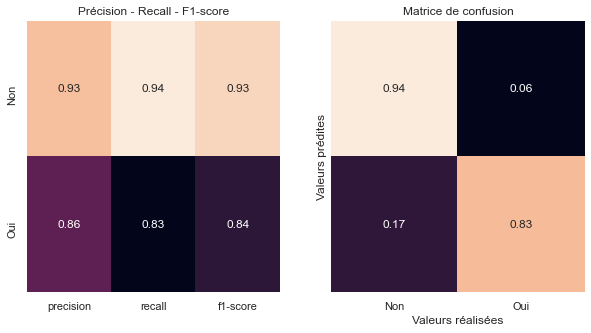

In [12]:
%%time
from xgboost import XGBClassifier

param_grid = {
              "learning_rate": [0.01, 0.1, 0.5],
              "max_depth" : [5, 8],
              "n_estimators": [200, 300],
              "colsample_bynode": [0.6, 0.8],
             }

xgb = GridSearchCV(XGBClassifier(random_seed=random_seed,
                                 verbosity=0,
                                 subsample=0.7,
                                 objective='binary:logistic',
                                 eval_metric='logloss'), 
                   param_grid, 
                   cv=3,
                   n_jobs=3)
xgb.fit(train_X, train_Y)
pred_Y = xgb.predict(test_X)
plot_perf(test_Y, pred_Y)
predictions['XGB'] = xgb.predict_proba(test_X)[:, 1]

In [13]:
xgb.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=0.6, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=8,
              num_parallel_tree=1, random_seed=12345, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
              tree_method='exact', validate_parameters=1, verbosity=0)

**Lightgbm**

Wall time: 3.75 s


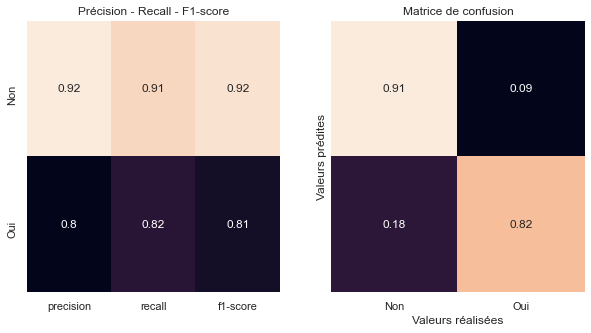

In [14]:
%%time
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder
train_X = train.drop(target, axis=1)
test_X = test.drop(target, axis=1)
for col in categorical_features:
    le = LabelEncoder().fit(train_X[col])
    train_X[col] = le.transform(train_X[col])
    test_X[col] = le.transform(test_X[col])

param_grid = {
              "learning_rate": [0.1, 0.5],
              "max_depth" : [6, 10],
              "n_estimators": [100, 200],
              "num_leaves": [30, 40]
             }

clf = LGBMClassifier(random_seed=random_seed,
                     categorical_feature=cat_features,
                     is_unbalance=True,
                     subsample=0.7,
                     metric='auc')
lgbm = GridSearchCV(clf, param_grid, cv=2, n_jobs=3)
lgbm.fit(train_X, train_Y)
pred_Y = lgbm.predict(test_X)
plot_perf(test_Y, pred_Y)

predictions['LGBM'] = lgbm.predict_proba(test_X)[:, 1]

In [15]:
lgbm.best_estimator_

LGBMClassifier(categorical_feature=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                    13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
                                    24],
               is_unbalance=True, max_depth=6, metric='auc', n_estimators=200,
               num_leaves=30, random_seed=12345, subsample=0.7)

**CatBoost**

Wall time: 10min 59s


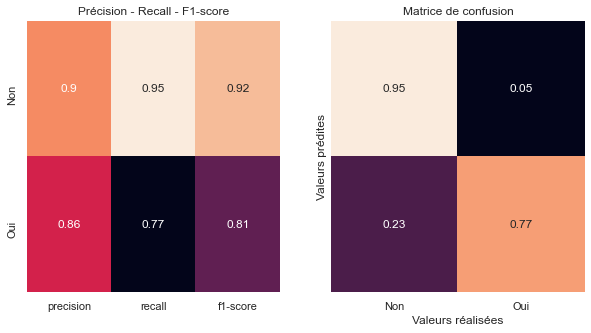

In [16]:
%%time 

from catboost import CatBoostClassifier
train_X = train.drop(target, axis=1)
test_X = test.drop(target, axis=1)

param_grid = {
              "learning_rate": [0.01, 0.1, 0.5],
              "max_depth" : [6, 10],
              "n_estimators": [200, 300],
              "min_data_in_leaf" : [2, 3, 4]
             }
cbt = GridSearchCV(CatBoostClassifier(random_seed=random_seed, 
                                      cat_features=cat_features,
                                      subsample=0.7,
                                      verbose=0), param_grid, cv=2, n_jobs=3)
cbt.fit(train_X, train_Y)
pred_Y = cbt.predict(test_X)
plot_perf(test_Y, pred_Y)

predictions['CBT'] = cbt.predict_proba(test_X)[:, 1]

In [17]:
print(cbt.best_estimator_.get_params())

{'learning_rate': 0.1, 'random_seed': 12345, 'verbose': 0, 'subsample': 0.7, 'max_depth': 10, 'n_estimators': 200, 'cat_features': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24], 'min_data_in_leaf': 2}


**Stacking**

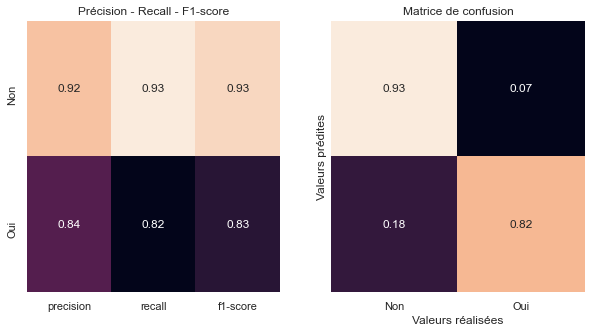

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier

from sklearn.base import clone

train_X = preprocessor.transform(train)
test_X = preprocessor.transform(test)

estimators = [
        ('rf', clone(rf.best_estimator_)),
        ('adb', clone(adb.best_estimator_)),
        ('xbg', clone(xgb.best_estimator_)),
        ('rgf', clone(rgf.best_estimator_)),
        ('ert', clone(ert.best_estimator_)),
        ('gbm', clone(gbm.best_estimator_))
]

stk = StackingClassifier(estimators=estimators, 
                         final_estimator=LogisticRegression(fit_intercept=False)
                        )

stk.fit(train_X, train_Y)
pred_Y = stk.predict(test_X)
plot_perf(test_Y, pred_Y)

predictions['STK'] = stk.predict_proba(test_X)[:, 1]

In [19]:
stk

StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(max_features=0.6,
                                                       min_samples_leaf=2,
                                                       n_estimators=200,
                                                       random_state=12345)),
                               ('adb',
                                AdaBoostClassifier(learning_rate=0.5,
                                                   random_state=12345)),
                               ('xbg',
                                XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=0.6,
                                              colsample_bytree=1,
                                              eval_metric='logloss', gamma=0,
                                              gpu_id=-...
                                              tree_method='exact',
                                              validate_parameters=1,
                                              verbosity=0)),
                               ('rgf',
                                RGFClassifier(max_leaf=200,
                                              min_samples_leaf=3)),
                               ('ert',
                                ExtraTreesClassifier(max_features=0.6,
                                                     min_samples_leaf=4,
                                                     n_estimators=200,
                                                     random_state=12345)),
                               ('gbm',
                                GradientBoostingClassifier(max_features=0.6,
                                                           min_samples_leaf=3,
                                                           random_state=12345))],
                   final_estimator=LogisticRegression(fit_intercept=False))

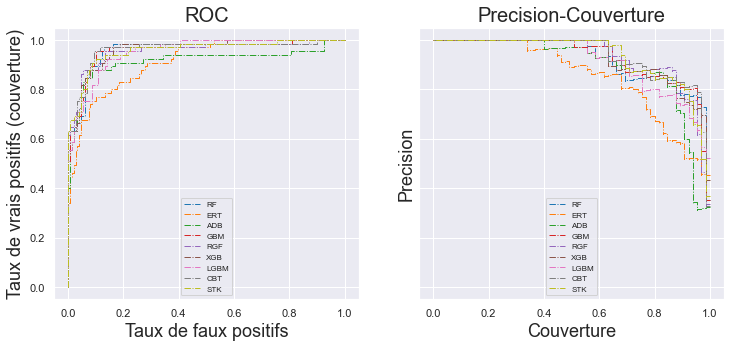

In [20]:
from matplotlib import cm
from sklearn.metrics import roc_curve, precision_recall_curve

def plot_performances(y_true, predictions):
    gradient = np.linspace(0, 1, 10)
    color_list = [ cm.tab10(x) for x in gradient ]

    fig, axes = plt.subplots(1, 2, figsize=(12, 5),
                         sharex=True, sharey=True)
    ax = axes[0]
    idx = 0
    for key, value in predictions.items():
        fpr, tpr, _ = roc_curve(y_true, value)
        ax.plot(fpr, tpr, linestyle='-.', c=color_list[idx], lw=1, label=key)
        idx = idx + 1

    ax.set_title("ROC", fontsize=20)
    ax.set_xlabel('Taux de faux positifs', fontsize=18)
    ax.set_ylabel('Taux de vrais positifs (couverture)', fontsize=18)
    ax.legend(loc='lower center', fontsize=8)

    ax = axes[1]
    idx = 0
    for key, value in predictions.items():
        precision, recall, _ = precision_recall_curve(y_true, value)
        ax.step(recall, precision, linestyle='-.', c=color_list[idx], lw=1, where='post', label=key)
        idx = idx + 1
    ax.set_title("Precision-Couverture", fontsize=20)
    ax.set_xlabel('Couverture', fontsize=18)
    ax.set_ylabel('Precision', fontsize=18)
    ax.legend(loc='lower center', fontsize=8)
    plt.show()
    
plot_performances(test_Y, predictions)

**Références :**   
[Overview of CatBoost](https://catboost.ai/docs/)   
[Welcome to LightGBM’s documentation!](https://lightgbm.readthedocs.io/en/latest/index.html)  
[Source](https://veroniquetremblay.github.io/analyse_de_donnees_et_apprentissage_statistique_en_R/arbres-et-for%C3%AAts-al%C3%A9atoires.html)
[Learning Nonlinear Functions Using Regularized Greedy Forest](https://arxiv.org/abs/1109.0887)   
[scikit-learn, Machine Learning in Python](https://scikit-learn.org/stable/)    
[Wikistat 2.0](https://github.com/wikistat)